In [1]:
!pip install opencv-python


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [3]:
TRAIN_DIR = r"C:\Users\Acer\Downloads\CRACK500\traindata\traindata"
os.path.exists(TRAIN_DIR)


True

In [4]:
image_files = []
mask_files = []

for file in os.listdir(TRAIN_DIR):
    if file.endswith(".jpg"):
        img_path = os.path.join(TRAIN_DIR, file)
        mask_name = file.replace(".jpg", "_mask.png")
        mask_path = os.path.join(TRAIN_DIR, mask_name)

        if os.path.exists(mask_path):
            image_files.append(img_path)
            mask_files.append(mask_path)

print("Images:", len(image_files))
print("Masks:", len(mask_files))


Images: 250
Masks: 250


In [5]:
import tensorflow as tf


In [6]:
IMG_SIZE = 256
BATCH_SIZE = 8


In [7]:
image_paths = tf.constant(image_files)
mask_paths  = tf.constant(mask_files)


In [8]:
def load_image_mask(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method="nearest")
    mask = tf.cast(mask > 0, tf.float32)

    return img, mask


In [9]:
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(100)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)


In [10]:
for images, masks in dataset.take(1):
    print(images.shape)
    print(masks.shape)


(8, 256, 256, 3)
(8, 256, 256, 1)


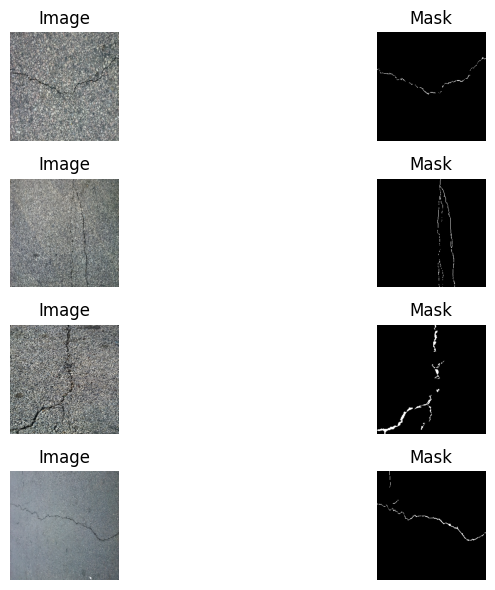

In [11]:
for images, masks in dataset.take(1):
    pass

plt.figure(figsize=(10,6))

for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(images[i])
    plt.title("Image")
    plt.axis("off")

    plt.subplot(4,2,2*i+2)
    plt.imshow(tf.squeeze(masks[i]), cmap="gray")
    plt.title("Mask")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [12]:
VAL_DIR = r"C:\Users\Acer\Downloads\CRACK500\valdata\valdata"

val_image_files = []
val_mask_files = []

for file in os.listdir(VAL_DIR):
    if file.endswith(".jpg"):
        img_path = os.path.join(VAL_DIR, file)
        mask_name = file.replace(".jpg", "_mask.png")
        mask_path = os.path.join(VAL_DIR, mask_name)

        if os.path.exists(mask_path):
            val_image_files.append(img_path)
            val_mask_files.append(mask_path)

print(len(val_image_files), len(val_mask_files))


50 50


In [13]:
val_image_paths = tf.constant(val_image_files)
val_mask_paths  = tf.constant(val_mask_files)

val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_image_paths, val_mask_paths)
)

val_dataset = val_dataset.map(
    load_image_mask,
    num_parallel_calls=tf.data.AUTOTUNE
)

val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)


In [14]:
for v_images, v_masks in val_dataset.take(1):
    print(v_images.shape)
    print(v_masks.shape)


(8, 256, 256, 3)
(8, 256, 256, 1)


In [15]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, 3, activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, 3, activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b = layers.Conv2D(256, 3, activation="relu", padding="same")(p2)
    b = layers.Conv2D(256, 3, activation="relu", padding="same")(b)

    # Decoder
    u1 = layers.UpSampling2D()(b)
    u1 = layers.Concatenate()([u1, c2])
    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(u1)
    c3 = layers.Conv2D(128, 3, activation="relu", padding="same")(c3)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.Concatenate()([u2, c1])
    c4 = layers.Conv2D(64, 3, activation="relu", padding="same")(u2)
    c4 = layers.Conv2D(64, 3, activation="relu", padding="same")(c4)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(c4)

    return models.Model(inputs, outputs)


In [16]:
model = build_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 256, 256, 64)      │          36,928 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 64)      │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 128)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 64, 64, 256)       │         590,080 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 128, 128, 256)     │               0 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128, 128, 384)     │               0 │ up_sampling2d[0][0],       │
│                               │                           │                 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 128, 128, 128)     │         442,496 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 128, 128, 128)     │         147,584 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 256, 256, 128)     │               0 │ conv2d_7[0][0]             │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 256, 256, 192)     │               0 │ up_sampling2d_1[0][0],     │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,883,137 (7.18 MB)

 Trainable params: 1,883,137 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2 * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )


In [18]:
bce = tf.keras.losses.BinaryCrossentropy()

def combined_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)


In [19]:
model.compile(
    optimizer="adam",
    loss=combined_loss,
    metrics=["accuracy"]
)


In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [21]:
history = model.fit(
    dataset,
    validation_data=val_dataset,
    epochs=3,
    callbacks=[early_stop]
)


Epoch 1/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 298s 9s/step - accuracy: 0.9394 - loss: 1.0989 - val_accuracy: 0.9752 - val_loss: 0.9674
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 277s 9s/step - accuracy: 0.9582 - loss: 0.9237 - val_accuracy: 0.9709 - val_loss: 0.8336
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 277s 9s/step - accuracy: 0.9684 - loss: 0.7883 - val_accuracy: 0.9767 - val_loss: 0.5994


In [22]:
for images, masks in val_dataset.take(1):
    preds = model.predict(images)
    break


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


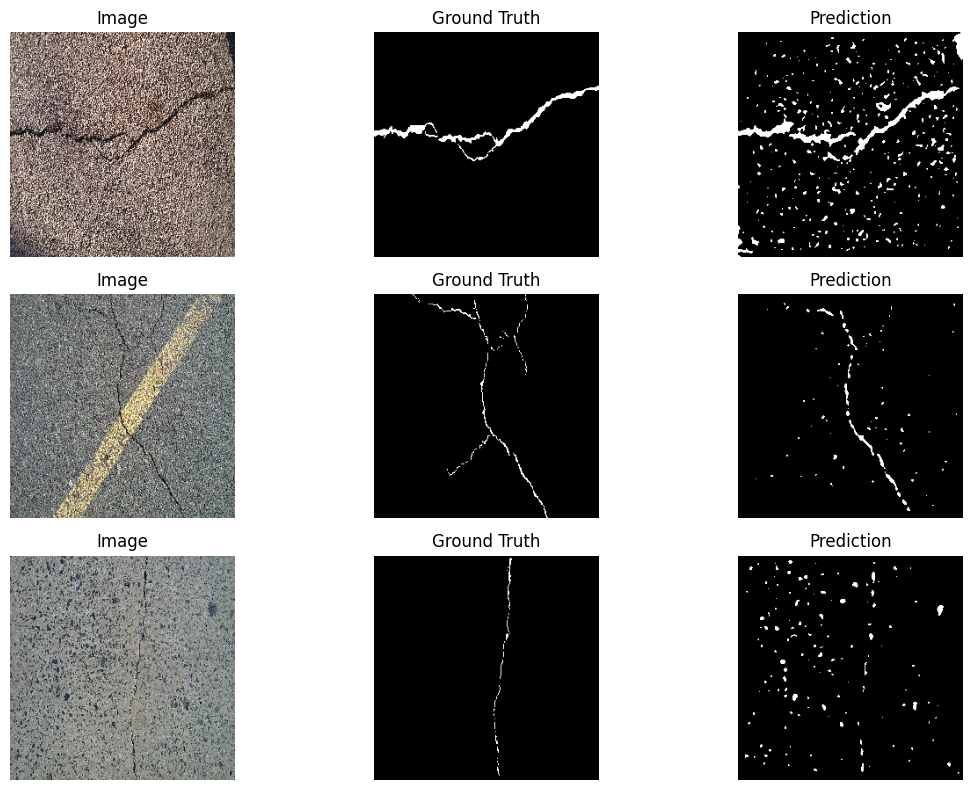

In [23]:
plt.figure(figsize=(12, 8))

for i in range(3):
    # Original image
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(images[i])
    plt.title("Image")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(tf.squeeze(masks[i]), cmap="gray")
    plt.title("Ground Truth")
    plt.axis("off")

    # Predicted mask
    plt.subplot(3, 3, 3*i + 3)
    plt.imshow(tf.squeeze(preds[i]) > 0.5, cmap="gray")
    plt.title("Prediction")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [24]:
import cv2
import numpy as np

pred = preds[0]
pred_bin = (pred > 0.5).astype(np.uint8)

kernel = np.ones((3,3), np.uint8)
pred_clean = cv2.morphologyEx(pred_bin, cv2.MORPH_OPEN, kernel)
pred_clean = cv2.morphologyEx(pred_clean, cv2.MORPH_CLOSE, kernel)


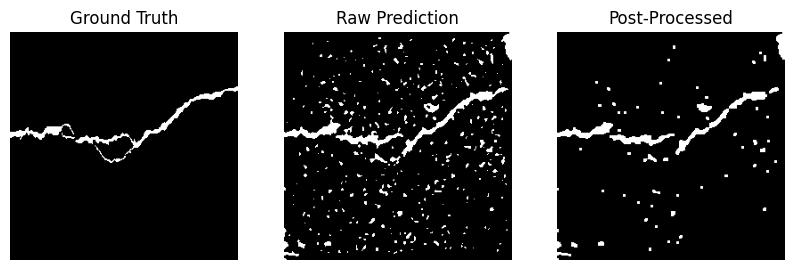

In [25]:
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.imshow(tf.squeeze(masks[0]), cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(tf.squeeze(preds[0]) > 0.5, cmap="gray")
plt.title("Raw Prediction")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred_clean, cmap="gray")
plt.title("Post-Processed")
plt.axis("off")

plt.show()


In [26]:
!pip install scikit-image


  Using cached scikit_image-0.26.0-cp313-cp313-win_amd64.whl.metadata (15 kB)
  Using cached networkx-3.6.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.26.0-cp313-cp313-win_amd64.whl (11.9 MB)
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached networkx-3.6.1-py3-none-any.whl (2.1 MB)

   ---------------------------------------- 0/4 [networkx]
   ---------------------------------------- 0/4 [networkx]
   ---------------------------------------- 0/4 [networkx]
   ---------------------------------------- 0/4 [networkx]
   ---------------------------------------- 0/4 [networkx]
   ---------------------------------------- 0/4 [networkx]
   ---------------------------------------- 0/4 [networkx]
   ---------------------------------------- 0/4 [networkx]
   -------------------

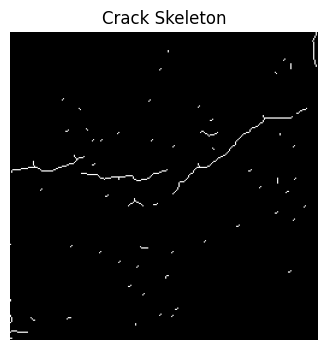

In [30]:
from skimage.morphology import skeletonize
skeleton = skeletonize(pred_clean.astype(bool))
plt.figure(figsize=(4,4))
plt.imshow(skeleton, cmap="gray")
plt.title("Crack Skeleton")
plt.axis("off")
plt.show()


In [33]:
crack_area = np.sum(pred_clean)
print("Crack area (pixels):", crack_area)
crack_length = np.sum(skeleton)
print("Crack length (pixels):", crack_length)


Crack area (pixels): 2901
Crack length (pixels): 488


In [34]:
avg_crack_width = crack_area / crack_length
print("Average crack width (pixels):", avg_crack_width)


Average crack width (pixels): 5.944672131147541


In [36]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

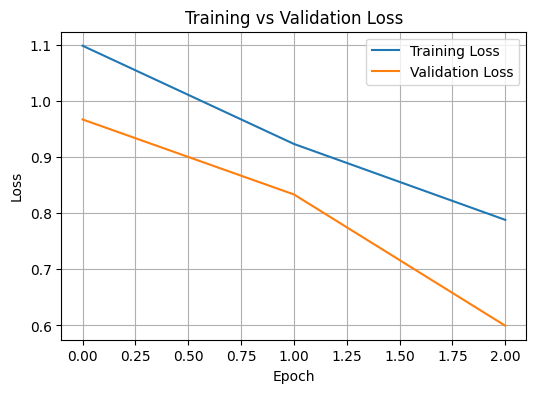

In [37]:
plt.figure(figsize=(6,4))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.show()


In [38]:
import numpy as np

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        np.sum(y_true) + np.sum(y_pred) + smooth
    )

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)


In [39]:
dice_scores = []
iou_scores = []

for images, masks in val_dataset:
    preds = model.predict(images, verbose=0)
    
    preds_bin = (preds > 0.5).astype(np.uint8)
    masks_bin = masks.numpy().astype(np.uint8)
    
    for i in range(preds_bin.shape[0]):
        dice_scores.append(
            dice_coefficient(masks_bin[i], preds_bin[i])
        )
        iou_scores.append(
            iou_score(masks_bin[i], preds_bin[i])
        )


In [40]:
print("Average Dice coefficient:", np.mean(dice_scores))
print("Average IoU score:", np.mean(iou_scores))


Average Dice coefficient: 0.48156507813401667
Average IoU score: 0.3423800378279404


In [76]:
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
    pred_clean, connectivity=8
)

# Keep only the largest crack region
largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
pred_main = (labels == largest_label).astype(np.uint8)


In [77]:
# Thresholds (pixel-based, adjustable)
AREA_MIN = 20        # ignore tiny detections
WIDTH_MINOR = 2.0
WIDTH_SEVERE = 5.0
LENGTH_MODERATE = 100
LENGTH_SEVERE = 200


In [78]:
def classify_severity(area, length, width):
    if area < AREA_MIN:
        return "No Crack"
    
    if width < WIDTH_MINOR and length < LENGTH_MODERATE:
        return "Minor Crack"
    
    if width < WIDTH_SEVERE and length < LENGTH_SEVERE:
        return "Moderate Crack"
    
    return "Severe Crack"


In [79]:
severity = classify_severity(
    crack_area,
    crack_length,
    avg_crack_width
)

print("Crack Severity:", severity)


Crack Severity: Severe Crack


In [80]:
import cv2
import numpy as np

def load_single_image(img_path, img_size=256):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    return np.expand_dims(img, axis=0)


In [81]:
def predict_crack_mask(model, img):
    pred = model.predict(img, verbose=0)[0]
    return pred
def post_process_mask(pred, thresh=0.5):
    pred_bin = (pred > thresh).astype(np.uint8)

    kernel = np.ones((3,3), np.uint8)
    pred_clean = cv2.morphologyEx(pred_bin, cv2.MORPH_OPEN, kernel)
    pred_clean = cv2.morphologyEx(pred_clean, cv2.MORPH_CLOSE, kernel)

    return pred_clean
from skimage.morphology import skeletonize

def get_clean_skeleton(pred_clean):
    skeleton = skeletonize(pred_clean.astype(bool))
    skeleton = skeleton.astype(np.uint8)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        skeleton, connectivity=8
    )

    if num_labels <= 1:
        return skeleton

    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    return (labels == largest).astype(np.uint8)
def compute_crack_metrics(pred_clean, skeleton):
    area = np.sum(pred_clean)
    length = np.sum(skeleton)
    width = area / length if length > 0 else 0
    return area, length, width


In [82]:
img_path = val_image_files[0]   # or any image path
img = load_single_image(img_path)

pred = predict_crack_mask(model, img)
pred_clean = post_process_mask(pred)
skeleton = get_clean_skeleton(pred_clean)

area, length, width = compute_crack_metrics(pred_clean, skeleton)
severity = classify_severity(area, length, width)

print("Crack Area:", area)
print("Crack Length:", length)
print("Crack Width:", width)
print("Severity:", severity)


Crack Area: 2869
Crack Length: 120
Crack Width: 23.908333333333335
Severity: Severe Crack


In [83]:
def analyze_image(img_path, model, img_size=256):
    # Load original image
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    H, W, _ = img_rgb.shape

    # Resize for model
    img_resized = cv2.resize(img_rgb, (img_size, img_size))
    img_norm = img_resized / 255.0
    img_input = np.expand_dims(img_norm, axis=0)

    # Predict
    pred = model.predict(img_input, verbose=0)[0]

    # Post-process at model scale
    pred_bin = (pred > 0.5).astype(np.uint8)
    kernel = np.ones((3,3), np.uint8)
    pred_clean = cv2.morphologyEx(pred_bin, cv2.MORPH_OPEN, kernel)
    pred_clean = cv2.morphologyEx(pred_clean, cv2.MORPH_CLOSE, kernel)

    # Resize mask BACK to original image size
    pred_clean_full = cv2.resize(
        pred_clean, (W, H), interpolation=cv2.INTER_NEAREST
    )

    # Skeleton (optional for metrics, not overlay)
    skeleton = skeletonize(pred_clean.astype(bool)).astype(np.uint8)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        skeleton, connectivity=8
    )
    if num_labels > 1:
        largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        skeleton = (labels == largest).astype(np.uint8)

    # Metrics (still computed at model scale)
    area = np.sum(pred_clean)
    length = np.sum(skeleton)
    width = area / length if length > 0 else 0

    severity = classify_severity(area, length, width)

    return img_rgb, pred_clean_full, severity, area, length, width


In [84]:
results = []

for img_path in val_image_files[:10]:  # first 10 for demo
    img, mask, severity, area, length, width = analyze_image(
        img_path, model
    )

    results.append({
        "image": img_path,
        "severity": severity,
        "area": area,
        "length": length,
        "width": width
    })


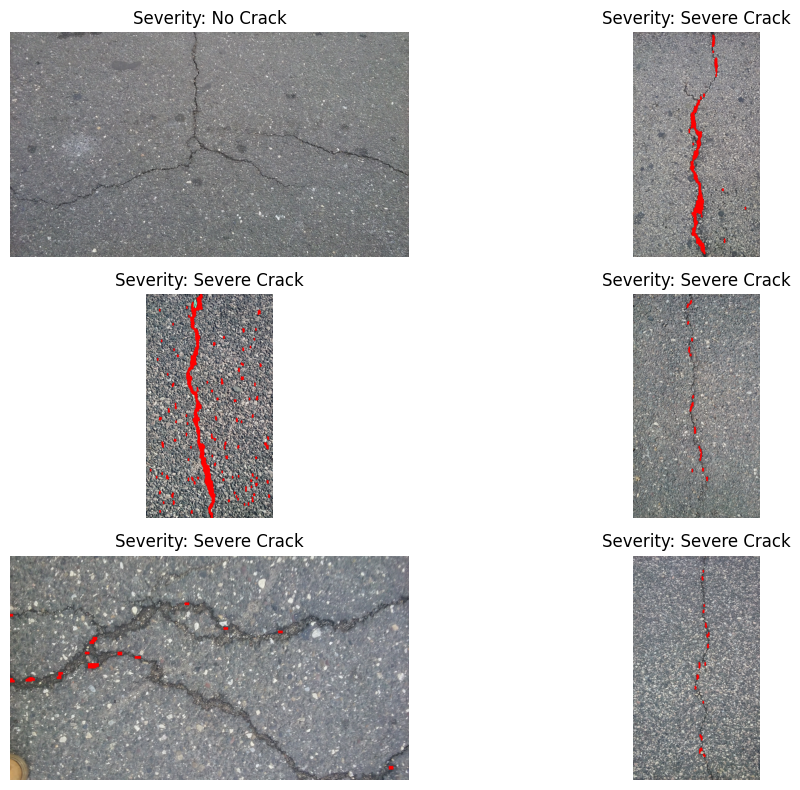

In [86]:
import random

sample_paths = random.sample(val_image_files, 6)

plt.figure(figsize=(12,8))

for i, img_path in enumerate(sample_paths):
    img, mask, severity, _, _, _ = analyze_image(img_path, model)

    overlay = img.copy()
    overlay[mask == 1] = [255, 0, 0]

    plt.subplot(3,2,i+1)
    plt.imshow(overlay)
    plt.title(f"Severity: {severity}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [88]:
model.save("crack_segmentation_model.keras")
